In [1]:
##############

import sys
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import csv
import io
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import astropy
from astropy import stats
import itertools
import os

###############

np.set_printoptions(suppress=True)
os.chdir("../data")  # moves working directory to data folder

In [10]:
npath = ''
cpath = '/Users/Clara Escanuela/Downloads/'

path = cpath

def optim_bins(mult_arry):
    
    width_arry = np.array([])
    
    for arry in mult_arry: 
        width_temp = astropy.stats.freedman_bin_width(arry, return_bins=False)
        width_arry = np.append(width_arry, width_temp)
    
    energy_res = np.max(width_arry)
    print(energy_res)
    flat_arry = np.concatenate(mult_arry, axis=0)
    
    return int(round((np.max(flat_arry) - np.min(flat_arry)) / energy_res, 0))

def hist_weights(rates, data):
    weights = []
    i = 0

    for event in data:
        weight = (rates[i]*np.ones_like(event))/len(event)
        weights.append(weight)
        i += 1
    
    return weights

def root_input(path, filename):
    rTree = uproot.open(path + filename)
    
    rTree_event = rTree['event_tree']
    rTree_data = rTree['data_tree']
    
    event_x_pos = np.array(rTree_event['event_x_pos'])
    event_E = np.array(rTree_event['event_E'])

    data_event = np.array(rTree_data['data_event'])
    #data_pmt = np.array(rTree_data['data_pmt'])
    data_time = np.array(rTree_data['data_time']) 

    data_index, count_scint = np.unique(data_event, return_counts=True)
    #split_pmt = np.split(data_pmt, np.cumsum(count_scint)) 
    split_time = np.split(data_time, np.cumsum(count_scint))

    return split_time, count_scint, event_x_pos, event_E

def pairwise(iterable):
    "s -> (s0,s1), (s2,s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

fname_sigdel = 'events_solar_delayed_xe.root'
fname_sig = 'events_solar_prompt_xe.root'
fname_bkg = 'events_alphagamma_xe.root'
fname_bkg1 = 'events_neutrons_40Ar_xe.root'
fname_bkga = 'events_Rn222_xe.root'

sig_split_time, sig_scint, sig_x, sig_event_E = root_input(path, fname_sig) 
sig_split_timedel, sig_scintdel, sig_xdel, sig_event_Edel = root_input(path, fname_sigdel) 
bkg_split_time, bkg_scint, bkg_x, bkg_event_E = root_input(path, fname_bkg)  
bkg1_split_time, bkg1_scint, bkg1_x, bkg1_event_E = root_input(path, fname_bkg1)  
bkga_split_time, bkga_scint, bkga_x, bkga_event_E = root_input(path, fname_bkga)  

#########################

bkg_split_time_temp = []
bkg_split_E_temp = []
for x, y in pairwise(bkg_split_time):
    bkg_split_time_temp.append(np.append(x,y))
    
bkg_split_time = bkg_split_time_temp
    
for x,y in pairwise(bkg_event_E):
    bkg_split_E_temp.append(np.append(x,y))
    
bkg_split_E = bkg_split_E_temp

sig_split_time_temp = []
sig_split_E_temp = []
for x, y in pairwise(sig_split_timedel):
    sig_split_time_temp.append(np.append(x,y))
    
sig_split_timedel = sig_split_time_temp
    
for x,y in pairwise(sig_event_Edel):
    sig_split_E_temp.append(x+y)
    
sig_event_Edel = sig_split_E_temp

outputtime = np.hstack((sig_split_timedel[0:4000], sig_split_time[0:6000]))
outputE = np.hstack((sig_event_Edel[0:4000], sig_event_E[0:6000]))
sig_split_time = outputtime
sig_event_E = outputE

C:\Users\Clara Escanuela\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


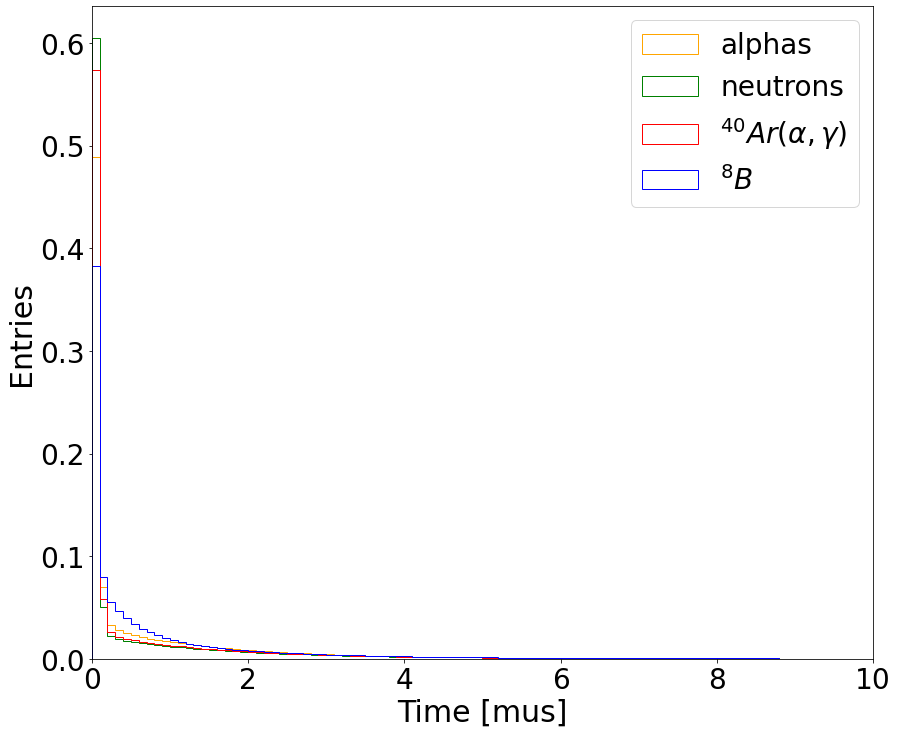

In [11]:
# Plot time distribution

data = [np.concatenate(sig_split_time), np.concatenate(bkg_split_time), np.concatenate(bkg1_split_time), np.concatenate(bkga_split_time)]
rates = [1, 1, 1, 1] # normalise

num_bins = 200

labels = [r'${}^8 B$', r'${}^{40} Ar(\alpha, \gamma)$', 'neutrons', 'alphas']
colors = ['blue', 'red', 'green', 'orange']

plt.figure(figsize=(14,12))

n, bins, patches = plt.hist(data, stacked = False, color=colors, bins=int(10/0.1), range=[0, 10], label=labels, histtype='step', weights=hist_weights(rates, data))

plt.xlabel('Time [mus]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Entries',fontsize=30)
plt.yticks(fontsize=28)
plt.xlim(0, 10)
#plt.yscale('log')

plt.legend(fontsize=28)

plt.show()

In [12]:
#Optimize time time window

bin_width = bins[1] - bins[0]

max_diff = 0
max_i = 0

total_integralS = bin_width*sum(n[0])
print(total_integralS)

total_integral_bkg = bin_width*sum(n[1])
print(total_integral_bkg)

ratioS_array = np.array([])
ratio_bkg_array = np.array([])
    
for i in range(0, num_bins):
    integralS = bin_width * sum(n[0][0:i])
    integral_bkg = bin_width * sum(n[1][0:i])
    ratioS = integralS/total_integralS   #fast to total ratio for signal
    ratioS_array = np.append(ratioS_array, ratioS)
    ratio_bkg = integral_bkg/total_integral_bkg   #fast to total ration for bkg
    ratio_bkg_array = np.append(ratio_bkg_array, ratio_bkg)
    diff = abs(ratioS - ratio_bkg)
    if diff>max_diff:
        max_diff = diff
        max_i = i

print(max_i*100)   #Optimal time window (ns)
max_time = max_i*100
print(max_diff)

0.09996040082375465
0.0999950814761304
100
0.1905551307294433


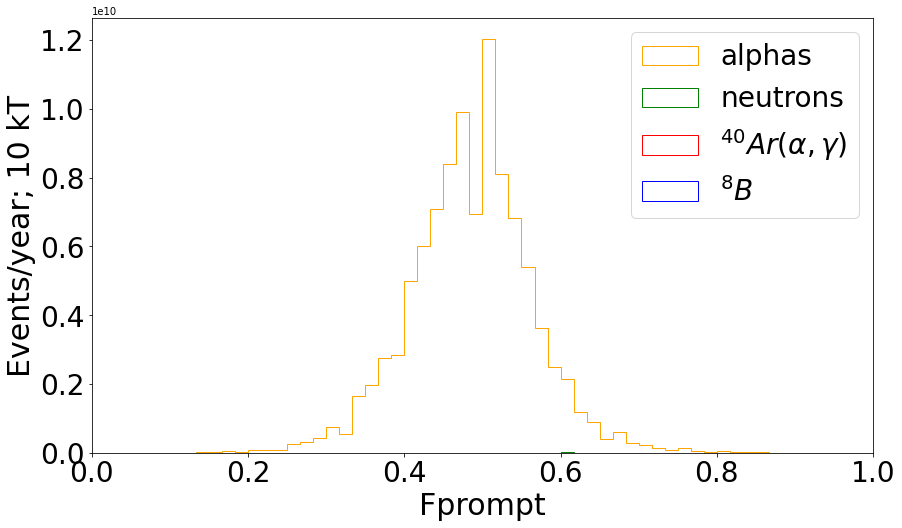

In [13]:
#Fprompt

def Fprompt(split_time, time):

    fprompt = np.array([])

    for event in split_time:
        if event.size > 0:
            fprompt = np.append(fprompt, len(event[event <= time*0.001])/len(event))
            
    return fprompt

#########################

max_time = max_time

###########################

Fprompt_sig = Fprompt(sig_split_time, max_time)
Fprompt_bkg = Fprompt(bkg_split_time, max_time)
Fprompt_bkg1 = Fprompt(bkg1_split_time, max_time)
Fprompt_bkga = Fprompt(bkga_split_time, max_time)

rates = [26700*0.64, 3000, 10**8, 10**(11)] # normalise

data = [Fprompt_sig, Fprompt_bkg, Fprompt_bkg1, Fprompt_bkga]


labels = [r'${}^8 B$', r'${}^{40} Ar(\alpha, \gamma)$', 'neutrons', 'alphas']
colors = ['blue', 'red', 'green', 'orange']

plt.figure(figsize=(14,8))
bins=60

n_, bins_, patches_ = plt.hist(data, stacked = False, weights=hist_weights(rates, data), color=colors, bins=bins, label=labels, histtype='step')

plt.xlabel('Fprompt',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Events/year; 10 kT',fontsize=30)
plt.yticks(fontsize=28)
plt.xlim([0, 1])

plt.legend(fontsize=28)

plt.show()

C:\Users\CLARAE~1\AppData\Local\Temp/ipykernel_7696/345936429.py:17: RuntimeWarning: invalid value encountered in double_scalars
  purity = np.append(purity, sign/(sign+back))
C:\Users\CLARAE~1\AppData\Local\Temp/ipykernel_7696/345936429.py:21: RuntimeWarning: invalid value encountered in double_scalars
  significance = np.append(significance, sign/np.sqrt(sign + back))


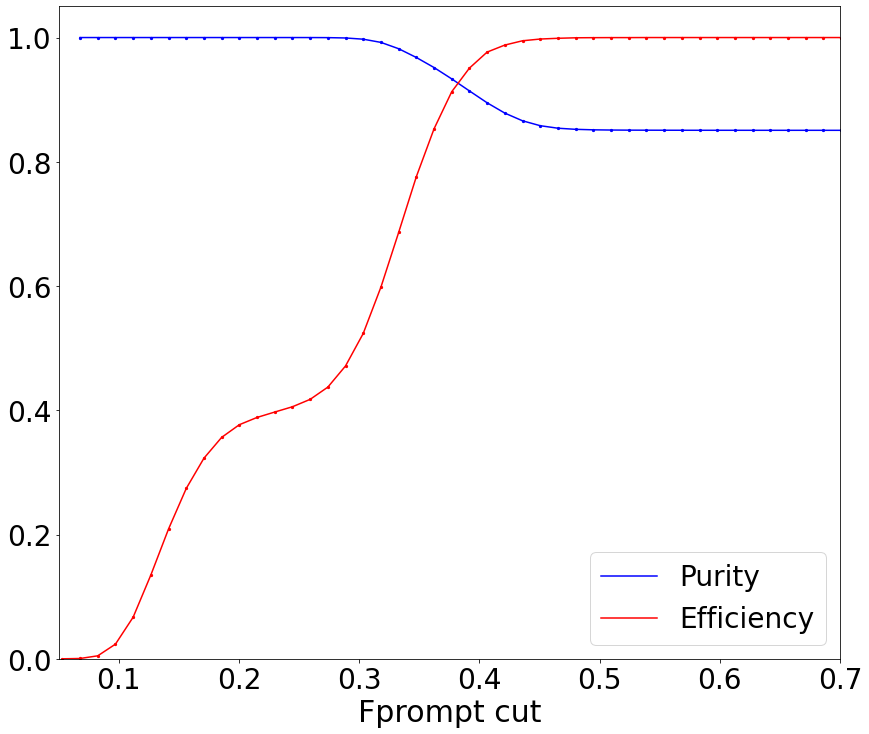

Time window:  200
Purity:  [       nan 0.93345337]
Efficiency:  [0.     0.9128]
Fprompt cut:  [0.05294118 0.37691566]
Signal acceptance:  [0.     0.9128]
Rejection efficiency:  [0.         0.37066286]
Significance:  [        nan 14.64278906]


In [7]:
bin_width = bins_[1] - bins_[0]

purity = np.array([])
efficiency = np.array([])
significance = np.array([])
signal_cut = np.array([])
back_cut = np.array([])

ntotal = n_[1]   #+n_[2]+n_[3]

total_sign = bin_width * sum(n_[0])
total_back = bin_width * sum(ntotal)

for i in range(0, bins):
    sign = bin_width * sum(n_[0][0:i])
    back = bin_width * sum(ntotal[0:i])
    purity = np.append(purity, sign/(sign+back))
    efficiency = np.append(efficiency, sign/total_sign)
    signal_cut = np.append(signal_cut, sign/total_sign)
    back_cut = np.append(back_cut, back/total_back)
    significance = np.append(significance, sign/np.sqrt(sign + back))

plt.figure(figsize=(14,12))

sig_label = r'Purity'
bkg_label = r'Efficiency'

plt.scatter(bins_[0:bins], purity, s = 20, marker='.', color='blue')
plt.plot(bins_[0:bins], purity, color='blue', label=sig_label)
plt.scatter(bins_[0:bins], efficiency, s = 20,  marker='.', color='red')
plt.plot(bins_[0:bins], efficiency, color='red', label=bkg_label)

idx = np.argwhere(np.diff(np.sign(purity - efficiency))).flatten()
#plt.plot(bins_[0:bins][idx], purity[idx], 'go')

plt.ylabel('', fontsize=30)
plt.xlabel(r'Fprompt cut', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(fontsize=28)
plt.ylim(0,1.05)
plt.xlim(0.05, 0.7)

plt.savefig('../figures/purity_efficiencyAG.png', bbox_inches='tight')

plt.show()

print("Time window: ", max_time)
print("Purity: ", purity[idx])
print("Efficiency: ", efficiency[idx])
print("Fprompt cut: ", bins_[0:bins][idx])
print("Signal acceptance: ", signal_cut[idx])
print("Rejection efficiency: ", back_cut[idx])
print("Significance: ", significance[idx])

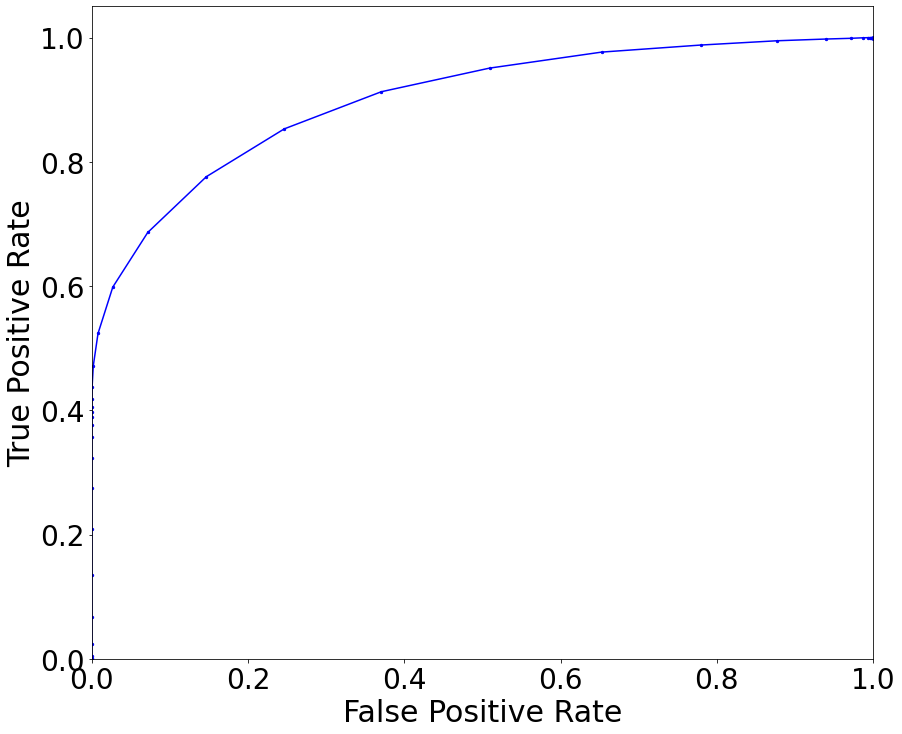

In [8]:
plt.figure(figsize=(14,12))

sig_label = r'Purity'
bkg_label = r'Efficiency'

num_mask = 2000
scint_mask = 1000

plt.scatter(back_cut, signal_cut, s = 22, marker='.', color='blue')
plt.plot(back_cut, signal_cut, color='blue')

plt.ylabel('True Positive Rate', fontsize=30)
plt.xlabel(r'False Positive Rate', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.ylim(0,1.05)
plt.xlim(0,1)
#plt.xscale('log')

#plt.savefig('../figures/.png', bbox_inches='tight')

plt.show()

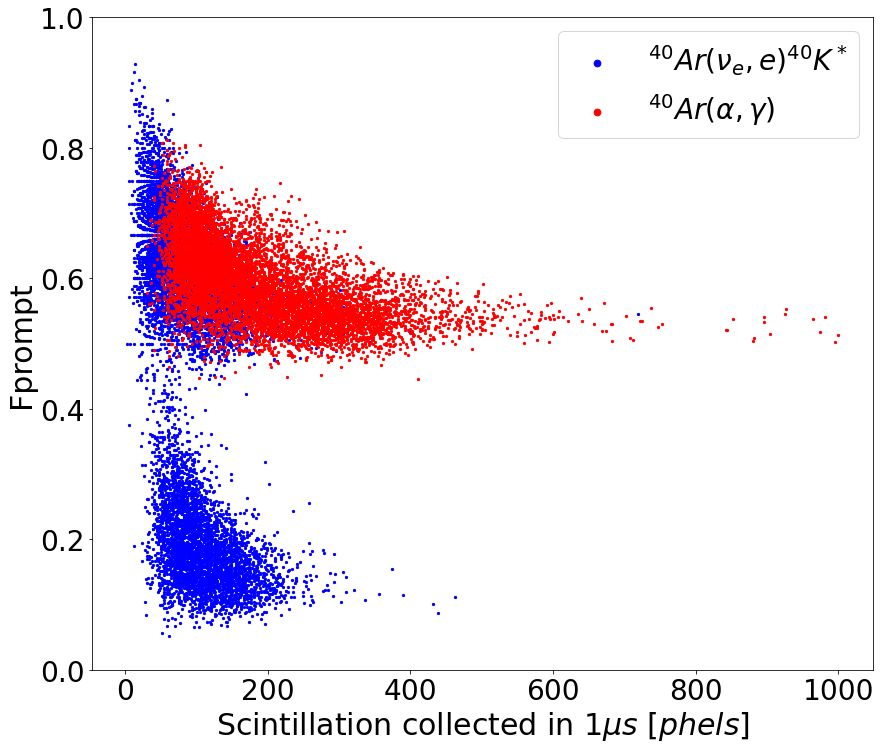

In [14]:
#########################

def scint_timewindow(split_time, set_time):
    #time is in microseconds
    i = 0
    scint_output = np.array([])

    for time in split_time:
        mask = (time <= set_time)
    
        if time.size > 0:
            scint_output = np.append(scint_output, len(time[mask])) # number of photons detected in time window
        i += 1
    
    return scint_output


t_window = 1

signl_wind = scint_timewindow(sig_split_time, t_window)
bkg_wind = scint_timewindow(bkg_split_time, t_window)

#########################

plt.figure(figsize=(14,12))

sig_label = r'$^{40}Ar(\nu_e, e)^{40}{K}^*$'
bkg_label = r'${}^{40} Ar(\alpha, \gamma)$'

num_mask = 2000
scint_mask = 1000
plt.scatter(signl_wind[signl_wind < scint_mask], Fprompt_sig[signl_wind < scint_mask], s = 20, label=sig_label, marker='.', color='blue')

plt.scatter(bkg_wind[bkg_wind < scint_mask], Fprompt_bkg[bkg_wind < scint_mask], s = 20, label=bkg_label, marker='.', color='red')
#plt.axhline(y=0.2, color='black', linestyle='dashed', linewidth=0.7)

plt.ylabel('Fprompt', fontsize=30)
plt.xlabel(r'Scintillation collected in $1 \mu s$ [$phels$]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(markerscale=3, fontsize=28)
plt.ylim(0,1)

plt.show()